### Setting ###

In [1]:
# Google Drive Mount
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Install foundation model - Segment Anything
#!pip install git+https://github.com/facebookresearch/segment-anything.git

In [3]:
# libraries
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import transforms

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

In [4]:
# device setting
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

print(device)

cuda:0


In [5]:
# environment setting
batch_size = 4
epochs = 10
lr = 0.001
weight_decay = 0.0005
alpha = 0.8
gamma = 2

In [6]:
# directory setting
class ROOTDIR:
    image = "/home/kmk/COSE474Project/data/images/"
    mask = "/home/kmk/COSE474Project/data/masks/"
    bbox = "/home/kmk/COSE474Project/data/"

### Data example ###

In [7]:
images = sorted(glob.glob(ROOTDIR.image + "*.jpg"))
masks = sorted(glob.glob(ROOTDIR.mask + "*.jpg"))
bbox_path = ROOTDIR.bbox + "kavsir_bboxes.json"
fns = sorted([i.split("/")[-1].split(".")[0] for i in images])

In [8]:
# bboxes
with open(bbox_path, 'r') as f:
    bbox_data = json.load(f)

In [9]:
for fn in fns:
    if len(bbox_data[fn]["bbox"]) != 1:
        del bbox_data[fn]
        fns.remove(fn)
        images.remove(ROOTDIR.image + fn + ".jpg")
        masks.remove(ROOTDIR.mask + fn + ".jpg")

In [10]:
len(images), len(masks), len(fns)

(947, 947, 947)

In [11]:
# train/val/test split (8:1:1)
train_images, val_images, train_masks, val_masks, train_fns, val_fns = train_test_split(images, masks, fns, test_size=0.2)
val_images, test_images, val_masks, test_masks, val_fns, test_fns = train_test_split(val_images, val_masks, val_fns, test_size=0.5)

In [12]:
len(train_images), len(val_images), len(test_images)

(757, 95, 95)

In [13]:
def get_bbox(data, fn):
    bbox_dict = data[fn]["bbox"][0]
    
    x_min = bbox_dict['xmin']
    x_max = bbox_dict['xmax']
    y_min = bbox_dict['ymin']
    y_max = bbox_dict['ymax']
        
    bbox = [x_min, y_min, x_max, y_max]
    
    return bbox

In [14]:
def show_bbox(bbox):
    ax = plt.gca()
    
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
        
    rect = patches.Rectangle((bbox[0], bbox[1]), w, h, color="blue", fill=False)
        
    ax.add_patch(rect)

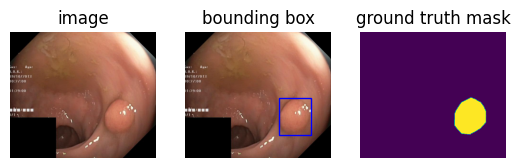

In [15]:
ex_img = Image.open(train_images[0]).convert("RGB")
ex_mask = Image.open(train_masks[0]).convert("L")
ex_bbox = get_bbox(bbox_data, train_fns[0])

plt.subplot(1, 3, 1)
plt.imshow(ex_img)
plt.title("image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ex_img)
show_bbox(ex_bbox)
plt.title("bounding box")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ex_mask)
plt.title("ground truth mask")
plt.axis("off")

plt.show()

### Zero shot prediction ###

In [16]:
# SAM model
model_type = "vit_h"
sam_checkpoint = "/home/kmk/COSE474Project/sam_vit_h_4b8939.pth"
# mask generator
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
# inputs
predictor.set_image(np.array(ex_img))
# predict
pred_mask, scores, logits = predictor.predict(point_coords=None, point_labels=None, box=np.array(ex_bbox),
                                multimask_output=False)

In [17]:
def show_mask(mask):
    ax = plt.gca()
    
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    ax.imshow(mask_image)

(-0.5, 611.5, 529.5, -0.5)

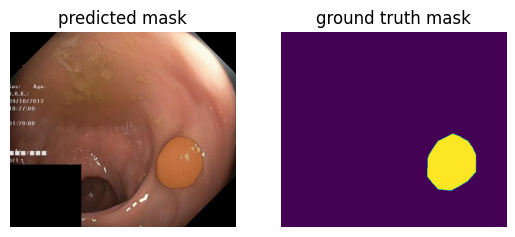

In [18]:
plt.subplot(1, 2, 1)
plt.imshow(ex_img)
show_mask(pred_mask)
plt.title("predicted mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ex_mask)
plt.title("ground truth mask")
plt.axis("off")

### Prepare Dataset ###

In [19]:
# Dataset
class MedDataset(Dataset):
    def __init__(self, img_dir, mask_dir, bbox_data, fns, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.bbox_data = bbox_data
        self.fns = fns
        self.transform = transform

    # img list 길이
    def __len__(self):
        return len(self.img_dir)

    # get image, label
    def __getitem__(self, idx):
        img = self.img_dir[idx]
        label = self.mask_dir[idx]
        fn = self.fns[idx]
        
        img = Image.open(img).convert("RGB")
        label = Image.open(label).convert("L")
        
        # get bounding box
        prompt = np.array(get_bbox(self.bbox_data, fn))
        
        if self.transform:
            image, mask, bbox = self.transform(image=img, mask=label, bbox=prompt)
        
        return image, mask, bbox

In [20]:
# Image preprocess for SAM
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size)
        self.to_tensor = transforms.ToTensorV2()
    
    def __call__(self, image, mask, bbox):
        image = np.array(image)
        mask = np.array(mask)
        bbox = np.array(bbox)
                
        h1, w1, _ = image.shape
        image = self.transform.apply_image(image)
        mask = torch.tensor(self.transform.apply_image(mask))
        image = self.to_tensor(image=image)["image"]
        
        _, h2, w2 = image.shape
        max_dim = max(w2, h2)
        pad_w = (max_dim - w2) // 2
        pad_h = (max_dim - h2) // 2
        
        padding = (pad_w, pad_h, max_dim - w2 - pad_w, max_dim - h2 - pad_h)
        image = tf.Pad(padding)(image)
        mask = tf.Pad(padding)(mask)
        
        bbox = self.transform.apply_boxes(bbox, (h1, w1))
        bbox = [bbox[0][0] + pad_w, bbox[0][1] + pad_h, bbox[0][2] + pad_w, bbox[0][3] + pad_h]
        bbox = torch.tensor(bbox)
        
        return image, mask, bbox

In [21]:
transform = ResizeAndPad(1024)
train_data = MedDataset(img_dir=train_images, mask_dir=train_masks, bbox_data=bbox_data, fns=train_fns, transform=transform)
val_data = MedDataset(img_dir=val_images, mask_dir=val_masks, bbox_data=bbox_data, fns=val_fns, transform=transform)
test_data = MedDataset(img_dir=test_images, mask_dir=test_masks, bbox_data=bbox_data, fns=test_fns, transform=transform)

In [22]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

### Training ###

In [23]:
# Calculate Focal Loss
class FocalLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, targets):
        inputs = inputs.flatten()
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE
        return focal_loss

# Calculate Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = inputs.flatten(0, 2)
        intersection = (inputs * targets).sum()
        dice = (2, * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

In [24]:
def criterion(x, y):
    focal, dice = FocalLoss(), DiceLoss()
    
    y = y.to(device)
    x = x.to(device)
    
    return 20*focal(x, y) + dice(x, y)

In [25]:
def train_model(model, trainloader, optimizer, writer, i):
    train_running_loss = 0.0
    
    model.to(device)
    model.train()
    
    for j, (image, mask, bbox) in enumerate(tqdm(trainloader)):
        image = image.to(device)
        mask = mask.to(device)
        bbox = bbox.to(device)
            
        y_pred = model(pixel_values=image, input_boxes=bbox, multimask_output=False)
        y_pred = y_pred.pred_masks.squeeze(1)
        
        optimizer.zero_grad()
        
        loss = criterion(y_pred, mask)
        
        writer.add_scalar("Loss/train", loss, j+i*len(trainloader))
        train_running_loss += loss.item()*batch_size
        
        loss.backward()
            
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    
    return train_loss

In [26]:
def val_model(model, valloader, writer, i):
    model.to(device)
    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for j, (image, masks, bbox) in enumerate(tqdm(valloader)):
            image = image.to(device)
            mask = masks.to(device)
            bbox = bbox.to(device)
            
            y_pred = model(image, bbox, multimaks_output=False)
            
            loss = criterion(y_pred, mask)
            
            writer.add_scalar("Loss/val", loss, j+i*len(valloader))
            
            val_running_loss += loss.item() * batch_size
            
        val_loss = val_running_loss / (j+1)
        
        return val_loss

In [27]:
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.trace_func = trace_func
        
        self.counter = 0
        self.val_loss = None
        self.val_loss_min = np.Inf
        self.early_stop = False
        
    def __call__(self, val_loss, model, file_name):
        if self.val_loss is None:
            self.val_loss = val_loss
            self.save_checkpoint(val_loss, model, file_name)
        elif val_loss > self.val_loss + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.val_loss = val_loss
            self.save_checkpoint(val_loss, model, file_name)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, file_name):
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.4f} --> {self.val_loss:.4f}).")
            self.trace_func("Saving model...")
        torch.save(model.state_dict(), file_name)
        self.val_loss_min = val_loss

In [28]:
model = sam_model_registry[model_type](checkpoint=sam_checkpoint)

for param in model.image_encoder.parameters():
    param.requires_grad = False
    
for param in model.prompt_encoder.parameters():
    param.requires_grad = False
    
optimizer = optim.Adam(model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
es = EarlyStopping(patience=20, verbose=False, delta=0)
writer = SummaryWriter()

In [29]:
train_losses = []
val_losses = []

for i in tqdm(range(epochs)):
    train_loss = train_model(model=model, trainloader=train_dataloader, optimizer=optimizer, writer=writer, i=i)
    val_loss = val_model(model=model, valloader=val_dataloader, writer=writer, i=i)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    
    TRAINED_MODEL = f"/home/kmk/COSE474Project/checkpoint/segmentation_{i}_epoch.pth"
    
    es(val_loss, model, TRAINED_MODEL)
    
    if es.early_stop:
        writer.close()
        break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

TypeError: forward() got an unexpected keyword argument 'pixel_values'